# Chapter 2: Understanding g2o File Format - 실습

## 🎯 학습 목표

이 실습에서는 SLAM의 표준 데이터 형식인 g2o 파일을 실제로 파싱하고 활용하는 방법을 익힙니다.

**핵심 역량:**
- ✅ Production-ready g2o 파서 구현
- ✅ 강건한 에러 처리와 유연한 포맷 지원
- ✅ Information Matrix의 실제 활용법
- ✅ 디버깅과 시각화 연결
- ✅ 성능 최적화 기법

> 💡 **이론 복습**: g2o의 개념과 수학적 배경은 [이론 강의](lectures/chapter02_understanding_g2o_format_theory.md)를 참고하세요.

## 📚 이론과 코드의 연결점

### g2o 파서의 실제 구현 도전 과제

**1. 포맷의 다양성 문제**
```bash
# 실제로 마주치는 다양한 g2o 포맷들
VERTEX_SE2 1 0.0 0.0 0.0          # 표준
VERTEX2 1 0.0 0.0 0.0             # TORO 스타일
VERTEX_SE2 1 0 0 0                # 정수형 (파싱 실패 위험!)
```

**2. Information Matrix 파싱의 함정**
```python
# ❌ 초보자의 실수: 대칭성 무시
info = [[500, 0, 0],
        [0, 500, 0],    # 실제로는 상삼각만 저장됨!
        [0, 0, 100]]
        
# ✅ 올바른 파싱: 상삼각 → 대칭 행렬
upper_triangular = [500, 0, 500, 0, 0, 100]  # 6개 원소
```

**3. 실시간 SLAM의 메모리 관리**
```python
# 문제: 100만 개 포즈 = 수 GB 메모리
# 해결: 슬라이딩 윈도우, 키프레임 선택, 증분적 처리
```

### 실제 SLAM 시스템에서의 활용

**Visual SLAM (ORB-SLAM3)**
- 키프레임 결정 → VERTEX 생성
- 특징점 매칭 → EDGE 계산
- Bundle Adjustment → g2o 최적화

**LiDAR SLAM (LeGO-LOAM)**
- Point cloud 정합 → 상대 포즈
- ICP 수렴도 → Information 값
- Loop detection → Long-range EDGE

## 🔧 필요한 라이브러리 임포트

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
import os
from pathlib import Path

# Chapter 1에서 정의한 함수들
def quat_to_rotmat(qx, qy, qz, qw):
    rotation = Rotation.from_quat([qx, qy, qz, qw])
    return rotation.as_matrix()

def rotmat_to_rotvec(R):
    rotation = Rotation.from_matrix(R)
    rotvec = rotation.as_rotvec()
    return rotvec

def se2_to_se3(x, y, theta):
    """SE(2) → SE(3) 변환 (2D를 3D로 확장)"""
    rotation = Rotation.from_euler("z", theta)
    R = rotation.as_matrix()
    t = np.array([x, y, 0.0])
    return R, t

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


## 1. g2o 파일 포맷 실전 가이드

### 1.1 포맷 다양성 처리하기

g2o 파일은 여러 변형이 존재합니다. 실제 프로젝트에서 마주치는 상황들:

```python
# 실제 파일에서 발견되는 다양한 형태들
examples = [
    "VERTEX_SE2 1 0.0 0.0 0.0",          # 표준 g2o
    "VERTEX2 1 0.0 0.0 0.0",             # TORO 레거시
    "VERTEX_SE2 1 0 0 0",                # 정수형 (주의!)
    "VERTEX_SE2 1 0.0 0.0 0.0 # comment", # 주석 포함
    "VERTEX_SE2   1    0.0   0.0   0.0",  # 불규칙한 공백
]
```

### 1.2 코드에서 이론 구현하기

**상삼각 행렬 저장의 이유**
```python
# 6x6 행렬 = 36개 원소
# 대칭 행렬이므로 상삼각만 = 21개 원소
# 메모리 절약: 42% 감소!

def upper_triangular_indices(n):
    """n×n 행렬의 상삼각 인덱스 계산"""
    indices = []
    for i in range(n):
        for j in range(i, n):
            indices.append((i, j))
    return indices
```

### 💡 실무 디버깅 팁

**1. 파싱 실패의 주요 원인들**
```python
# 원인 1: 부동소수점 파싱 실패
try:
    value = float("1.23e-5")  # OK
    value = float("1,23")     # ERROR: 쉼표 사용
except ValueError as e:
    print(f"파싱 실패: {e}")

# 원인 2: 파일 인코딩 문제
# 해결: encoding='utf-8' 명시적 지정
```

**2. Information Matrix 검증**
```python
def validate_information_matrix(info):
    """Information Matrix 유효성 검사"""
    # 1. 대칭성 확인
    if not np.allclose(info, info.T):
        return False, "비대칭 행렬"
    
    # 2. 양정치성 확인
    eigenvalues = np.linalg.eigvals(info)
    if np.any(eigenvalues <= 0):
        return False, f"음의 고유값: {eigenvalues.min()}"
    
    # 3. 조건수 확인
    cond = np.linalg.cond(info)
    if cond > 1e10:
        return False, f"조건수 너무 큼: {cond:.2e}"
    
    return True, "유효한 Information Matrix"
```

### 🔧 실제 SLAM 시스템 통합

**ROS2 통합 예시**
```python
# ROS2 토픽에서 g2o로 변환
def ros_odometry_to_g2o_edge(odom_msg):
    # Covariance → Information
    cov = np.array(odom_msg.pose.covariance).reshape(6, 6)
    info = np.linalg.inv(cov + 1e-6 * np.eye(6))  # 정규화
    
    # 상삼각 추출
    upper = info[np.triu_indices(6)]
    return upper
```

## 2. g2o 파서 구현

이제 실제로 g2o 파일을 파싱하는 함수를 구현해봅시다.

In [19]:
class G2OParser:
    """g2o 파일 파서 클래스"""
    
    def __init__(self):
        self.poses = {}  # {id: {'R': rotation_matrix, 't': translation}}
        self.edges = []  # [{'from': id1, 'to': id2, 'R': R, 't': t, 'information': I}]
        self.dimension = None  # 2D or 3D
        
    def parse_information_matrix(self, data, size):
        """상삼각 행렬에서 전체 대칭 행렬 복원
        
        g2o는 information matrix를 상삼각 형태로 저장합니다.
        예: 3×3 행렬의 경우 [a, b, c, d, e, f] → [[a,b,c],[b,d,e],[c,e,f]]
        """
        information_upper = np.array(data, dtype=float)
        information_matrix = np.zeros((size, size))
        
        # 상삼각 원소를 행렬에 채우기
        indices = np.triu_indices(size)
        information_matrix[indices] = information_upper
        
        # 대칭 행렬 만들기 (대각선 제외)
        information_matrix = information_matrix + information_matrix.T - np.diag(information_matrix.diagonal())
        
        return information_matrix
    
    def parse_vertex_se3(self, data):
        """SE(3) vertex 파싱"""
        node_id = int(data[1])
        x, y, z = map(float, data[2:5])
        qx, qy, qz, qw = map(float, data[5:9])
        
        R = quat_to_rotmat(qx, qy, qz, qw)
        t = np.array([x, y, z])
        
        self.poses[node_id] = {'R': R, 't': t, 'r': rotmat_to_rotvec(R)}
        
    def parse_vertex_se2(self, data):
        """SE(2) vertex 파싱"""
        node_id = int(data[1])
        x, y, theta = map(float, data[2:5])
        
        R, t = se2_to_se3(x, y, theta)
        
        self.poses[node_id] = {'R': R, 't': t, 'r': rotmat_to_rotvec(R)}
        
    def parse_edge_se3(self, data):
        """SE(3) edge 파싱"""
        id_from = int(data[1])
        id_to = int(data[2])
        
        # 상대 변환
        x, y, z = map(float, data[3:6])
        qx, qy, qz, qw = map(float, data[6:10])
        
        R = quat_to_rotmat(qx, qy, qz, qw)
        t = np.array([x, y, z])
        
        # Information matrix (6×6)
        if len(data) >= 31:  # 10 + 21 elements
            info_data = list(map(float, data[10:31]))
            information = self.parse_information_matrix(info_data, 6)
        else:
            # 기본 information matrix
            information = np.eye(6)
            
        edge = {
            'from': id_from,
            'to': id_to,
            'R': R,
            't': t,
            'r': rotmat_to_rotvec(R),
            'information': information
        }
        self.edges.append(edge)
        
    def parse_edge_se2(self, data):
        """SE(2) edge 파싱"""
        id_from = int(data[1])
        id_to = int(data[2])
        
        # 상대 변환
        dx, dy, dtheta = map(float, data[3:6])
        R, t = se2_to_se3(dx, dy, dtheta)
        
        # Information matrix (3×3 → 6×6으로 확장)
        if len(data) >= 12:  # 6 + 6 elements for 3×3 matrix
            info_data_se2 = list(map(float, data[6:12]))
            info_se2 = self.parse_information_matrix(info_data_se2, 3)
            
            # SE(2) → SE(3) information matrix 확장
            information = np.eye(6)
            information[:2, :2] = info_se2[:2, :2]  # x, y
            information[5, 5] = info_se2[2, 2]      # theta → z rotation
        else:
            information = np.eye(6)
            
        edge = {
            'from': id_from,
            'to': id_to,
            'R': R,
            't': t,
            'r': rotmat_to_rotvec(R),
            'information': information
        }
        self.edges.append(edge)
    
    def parse_file(self, filename):
        """g2o 파일 파싱"""
        print(f"📂 파일 읽기: {filename}")
        
        with open(filename, 'r') as f:
            for line_num, line in enumerate(f, 1):
                data = line.strip().split()
                if not data:
                    continue
                    
                tag = data[0]
                
                try:
                    if tag == 'VERTEX_SE3:QUAT':
                        self.dimension = 3
                        self.parse_vertex_se3(data)
                    elif tag in ['VERTEX_SE2', 'VERTEX2']:
                        self.dimension = 2
                        self.parse_vertex_se2(data)
                    elif tag == 'EDGE_SE3:QUAT':
                        self.parse_edge_se3(data)
                    elif tag in ['EDGE_SE2', 'EDGE2']:
                        self.parse_edge_se2(data)
                except Exception as e:
                    print(f"⚠️  라인 {line_num} 파싱 오류: {e}")
                    print(f"    내용: {line.strip()}")
                    
        print(f"✅ 파싱 완료!")
        print(f"   - 포즈 수: {len(self.poses)}")
        print(f"   - 엣지 수: {len(self.edges)}")
        print(f"   - 차원: {self.dimension}D")
        
        return self.poses, self.edges

print("✅ G2OParser 클래스 정의 완료!")

✅ G2OParser 클래스 정의 완료!


In [20]:
class RobustG2OParser(G2OParser):
    """Production-ready g2o 파서 with 에러 처리와 검증"""
    
    def __init__(self, strict_mode=False):
        super().__init__()
        self.strict_mode = strict_mode  # True면 에러시 중단
        self.errors = []  # 파싱 에러 로그
        self.warnings = []  # 경고 메시지
        self.statistics = {
            'total_lines': 0,
            'parsed_lines': 0,
            'error_lines': 0,
            'vertex_types': {},
            'edge_types': {}
        }
        
    def validate_and_fix_information(self, info_matrix, size):
        """Information Matrix 검증 및 자동 수정"""
        # 1. 대칭성 강제
        info_matrix = (info_matrix + info_matrix.T) / 2
        
        # 2. 양정치성 확보
        eigenvalues, eigenvectors = np.linalg.eigh(info_matrix)
        
        # 음의 고유값 수정
        min_eigenvalue = 1e-6
        if np.any(eigenvalues < min_eigenvalue):
            self.warnings.append(f"음의 고유값 발견: {eigenvalues.min():.2e}")
            eigenvalues = np.maximum(eigenvalues, min_eigenvalue)
            info_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
        
        # 3. 조건수 개선
        max_condition = 1e8
        condition = eigenvalues.max() / eigenvalues.min()
        if condition > max_condition:
            self.warnings.append(f"높은 조건수: {condition:.2e}")
            # 정규화 추가
            info_matrix += np.eye(size) * eigenvalues.max() / max_condition
        
        return info_matrix
    
    def parse_line_safe(self, line, line_num):
        """안전한 라인 파싱 with 에러 복구"""
        try:
            # 주석 제거
            if '#' in line:
                line = line[:line.index('#')]
            
            data = line.strip().split()
            if not data:
                return
            
            tag = data[0].upper()  # 대소문자 무시
            
            # 태그 정규화 (TORO 호환성)
            tag_mapping = {
                'VERTEX2': 'VERTEX_SE2',
                'EDGE2': 'EDGE_SE2',
                'VERTEX3': 'VERTEX_SE3:QUAT',
                'EDGE3': 'EDGE_SE3:QUAT'
            }
            tag = tag_mapping.get(tag, tag)
            
            # 통계 업데이트
            if tag.startswith('VERTEX'):
                self.statistics['vertex_types'][tag] = self.statistics['vertex_types'].get(tag, 0) + 1
            elif tag.startswith('EDGE'):
                self.statistics['edge_types'][tag] = self.statistics['edge_types'].get(tag, 0) + 1
            
            # 파싱 수행
            if tag == 'VERTEX_SE3:QUAT':
                self.parse_vertex_se3_safe(data)
            elif tag == 'VERTEX_SE2':
                self.parse_vertex_se2_safe(data)
            elif tag == 'EDGE_SE3:QUAT':
                self.parse_edge_se3_safe(data)
            elif tag == 'EDGE_SE2':
                self.parse_edge_se2_safe(data)
            else:
                self.warnings.append(f"라인 {line_num}: 알 수 없는 태그 '{tag}'")
                
            self.statistics['parsed_lines'] += 1
            
        except Exception as e:
            self.statistics['error_lines'] += 1
            error_msg = f"라인 {line_num}: {str(e)}\n  내용: {line.strip()}"
            self.errors.append(error_msg)
            
            if self.strict_mode:
                raise RuntimeError(error_msg)
    
    def parse_vertex_se2_safe(self, data):
        """SE2 vertex 안전 파싱"""
        # 데이터 길이 검증
        if len(data) < 5:
            raise ValueError(f"SE2 vertex 데이터 부족: {len(data)} < 5")
        
        node_id = int(data[1])
        
        # 중복 ID 검사
        if node_id in self.poses:
            self.warnings.append(f"중복 vertex ID: {node_id}")
            return
        
        # 숫자 파싱 (정수도 처리)
        x = float(data[2])
        y = float(data[3]) 
        theta = float(data[4])
        
        # 각도 정규화 [-π, π]
        theta = np.arctan2(np.sin(theta), np.cos(theta))
        
        R, t = se2_to_se3(x, y, theta)
        self.poses[node_id] = {'R': R, 't': t, 'r': rotmat_to_rotvec(R)}
    
    def parse_edge_se2_safe(self, data):
        """SE2 edge 안전 파싱"""
        if len(data) < 6:
            raise ValueError(f"SE2 edge 데이터 부족: {len(data)} < 6")
        
        id_from = int(data[1])
        id_to = int(data[2])
        
        # Vertex 존재 확인 (지연 검사 옵션)
        if id_from not in self.poses or id_to not in self.poses:
            self.warnings.append(f"Edge {id_from}->{id_to}: vertex 아직 파싱 안됨")
            # 나중에 다시 처리하도록 큐에 저장할 수 있음
        
        dx = float(data[3])
        dy = float(data[4])
        dtheta = float(data[5])
        
        R, t = se2_to_se3(dx, dy, dtheta)
        
        # Information matrix 처리
        if len(data) >= 12:  # 6 + 6 for 3×3 info
            try:
                info_data = list(map(float, data[6:12]))
                info_se2 = self.parse_information_matrix(info_data, 3)
                info_se2 = self.validate_and_fix_information(info_se2, 3)
                
                # SE2 → SE3 확장
                information = np.eye(6)
                information[:2, :2] = info_se2[:2, :2]
                information[5, 5] = info_se2[2, 2]
            except:
                self.warnings.append(f"Edge {id_from}->{id_to}: Information matrix 파싱 실패, 기본값 사용")
                information = np.eye(6)
        else:
            information = np.eye(6)
        
        edge = {
            'from': id_from,
            'to': id_to,
            'R': R,
            't': t,
            'r': rotmat_to_rotvec(R),
            'information': information
        }
        self.edges.append(edge)
    
    def parse_file_streaming(self, filename, chunk_size=10000):
        """대용량 파일 스트리밍 파싱"""
        print(f"📂 스트리밍 파싱 시작: {filename}")
        
        with open(filename, 'r', encoding='utf-8') as f:
            chunk = []
            for line_num, line in enumerate(f, 1):
                self.statistics['total_lines'] += 1
                chunk.append((line_num, line))
                
                if len(chunk) >= chunk_size:
                    self._process_chunk(chunk)
                    chunk = []
                    print(f"  처리 중... {self.statistics['parsed_lines']} 라인 완료")
            
            # 마지막 청크 처리
            if chunk:
                self._process_chunk(chunk)
        
        self._finalize_parsing()
        
    def _process_chunk(self, chunk):
        """청크 단위 처리"""
        for line_num, line in chunk:
            self.parse_line_safe(line, line_num)
    
    def _finalize_parsing(self):
        """파싱 완료 후 검증 및 통계"""
        print(f"\n✅ 파싱 완료!")
        print(f"📊 통계:")
        print(f"  - 총 라인: {self.statistics['total_lines']}")
        print(f"  - 성공: {self.statistics['parsed_lines']}")
        print(f"  - 실패: {self.statistics['error_lines']}")
        print(f"  - 포즈: {len(self.poses)}")
        print(f"  - 엣지: {len(self.edges)}")
        
        if self.statistics['vertex_types']:
            print(f"\n  Vertex 타입:")
            for vtype, count in self.statistics['vertex_types'].items():
                print(f"    - {vtype}: {count}")
        
        if self.statistics['edge_types']:
            print(f"\n  Edge 타입:")
            for etype, count in self.statistics['edge_types'].items():
                print(f"    - {etype}: {count}")
        
        if self.warnings:
            print(f"\n⚠️  경고 ({len(self.warnings)}개):")
            for i, warning in enumerate(self.warnings[:5]):  # 처음 5개만
                print(f"  {i+1}. {warning}")
            if len(self.warnings) > 5:
                print(f"  ... 외 {len(self.warnings)-5}개")
        
        if self.errors:
            print(f"\n❌ 에러 ({len(self.errors)}개):")
            for i, error in enumerate(self.errors[:5]):
                print(f"  {i+1}. {error}")
            if len(self.errors) > 5:
                print(f"  ... 외 {len(self.errors)-5}개")
    
    def get_parsing_report(self):
        """파싱 결과 리포트 생성"""
        report = {
            'statistics': self.statistics,
            'warnings': self.warnings,
            'errors': self.errors,
            'data_quality': self._assess_data_quality()
        }
        return report
    
    def _assess_data_quality(self):
        """데이터 품질 평가"""
        quality = {
            'score': 100,
            'issues': []
        }
        
        # 에러율 체크
        error_rate = self.statistics['error_lines'] / max(self.statistics['total_lines'], 1)
        if error_rate > 0.01:
            quality['score'] -= 20
            quality['issues'].append(f"높은 에러율: {error_rate:.1%}")
        
        # 고아 vertex 체크
        referenced_vertices = set()
        for edge in self.edges:
            referenced_vertices.add(edge['from'])
            referenced_vertices.add(edge['to'])
        
        orphan_vertices = set(self.poses.keys()) - referenced_vertices
        if orphan_vertices:
            quality['score'] -= 10
            quality['issues'].append(f"고아 vertex {len(orphan_vertices)}개")
        
        # Loop closure 비율
        total_edges = len(self.edges)
        if total_edges > 0:
            loop_edges = sum(1 for e in self.edges if abs(e['from'] - e['to']) > 1)
            loop_ratio = loop_edges / total_edges
            if loop_ratio < 0.01:
                quality['score'] -= 10
                quality['issues'].append(f"Loop closure 부족: {loop_ratio:.1%}")
        
        return quality

print("✅ RobustG2OParser 클래스 정의 완료!")

✅ RobustG2OParser 클래스 정의 완료!


## 3. 예제 g2o 파일 생성

실제 데이터를 파싱하기 전에, 간단한 예제 파일을 만들어 봅시다.

In [21]:
# 에러가 포함된 테스트 g2o 파일 생성
error_test_content = """# 다양한 에러 케이스 테스트
VERTEX_SE2 0 0.0 0.0 0.0
VERTEX_SE2 1 1.0 0.0 0.0
vertex_se2 2 2.0 0.0 0.0  # 소문자 태그
VERTEX2 3 3.0 0.0 0.0      # TORO 형식
VERTEX_SE2 4 4 0 0         # 정수형 좌표
VERTEX_SE2 5 5.0 0.0       # 데이터 부족!
VERTEX_SE2 1 1.5 0.0 0.0   # 중복 ID!
VERTEX_SE2 six 6.0 0.0 0.0 # 잘못된 ID 형식

# 엣지 에러들
EDGE_SE2 0 1 1.0 0.0 0.0 500 0 500 0 0 500
EDGE_SE2 1 2 1.0 0.0 0.0 # Information matrix 없음
EDGE_SE2 2 10 1.0 0.0 0.0 500 0 500 0 0 500  # 존재하지 않는 vertex
EDGE_SE2 3 4 1,0 0.0 0.0 500 0 500 0 0 500   # 쉼표 사용
EDGE2 4 0 -4.0 0.0 0.0 700 0 700 0 0 700     # TORO 형식 loop closure

# 잘못된 Information matrix
EDGE_SE2 0 3 3.0 0.0 0.0 -100 0 500 0 0 500  # 음수 값
"""

with open('data/error_test.g2o', 'w') as f:
    f.write(error_test_content)

# 강건한 파서로 테스트
print("🧪 에러 처리 테스트:")
robust_parser = RobustG2OParser(strict_mode=False)  # strict_mode=False로 계속 진행
robust_parser.parse_file('data/error_test.g2o')

# 파싱 리포트 확인
report = robust_parser.get_parsing_report()
print(f"\n📋 데이터 품질 점수: {report['data_quality']['score']}/100")
for issue in report['data_quality']['issues']:
    print(f"  - {issue}")

🧪 에러 처리 테스트:
📂 파일 읽기: data/error_test.g2o
⚠️  라인 7 파싱 오류: could not convert string to float: '#'
    내용: VERTEX_SE2 5 5.0 0.0       # 데이터 부족!
⚠️  라인 9 파싱 오류: invalid literal for int() with base 10: 'six'
    내용: VERTEX_SE2 six 6.0 0.0 0.0 # 잘못된 ID 형식
⚠️  라인 15 파싱 오류: could not convert string to float: '1,0'
    내용: EDGE_SE2 3 4 1,0 0.0 0.0 500 0 500 0 0 500   # 쉼표 사용
✅ 파싱 완료!
   - 포즈 수: 4
   - 엣지 수: 5
   - 차원: 2D

📋 데이터 품질 점수: 100/100


In [22]:
# 간단한 사각형 경로 g2o 파일 생성
example_g2o_content = """# Simple square path example
VERTEX_SE2 0 0.0 0.0 0.0
VERTEX_SE2 1 1.0 0.0 0.0
VERTEX_SE2 2 1.0 1.0 1.5708
VERTEX_SE2 3 0.0 1.0 3.1416
VERTEX_SE2 4 0.0 0.0 -1.5708

# Odometry edges
EDGE_SE2 0 1 1.0 0.0 0.0 500.0 0.0 500.0 0.0 0.0 500.0
EDGE_SE2 1 2 0.0 1.0 1.5708 500.0 0.0 500.0 0.0 0.0 500.0
EDGE_SE2 2 3 -1.0 0.0 1.5708 500.0 0.0 500.0 0.0 0.0 500.0
EDGE_SE2 3 4 0.0 -1.0 1.5708 500.0 0.0 500.0 0.0 0.0 500.0

# Loop closure edge
EDGE_SE2 4 0 0.0 0.0 0.0 700.0 0.0 700.0 0.0 0.0 700.0
"""

# 파일 저장
os.makedirs('data', exist_ok=True)
with open('data/simple_square.g2o', 'w') as f:
    f.write(example_g2o_content)
    
print("✅ 예제 g2o 파일 생성 완료: data/simple_square.g2o")

✅ 예제 g2o 파일 생성 완료: data/simple_square.g2o


In [23]:
# 시각화 함수 정의
def visualize_pose_graph_2d(poses, edges, title="Pose Graph Visualization"):
    """2D Pose Graph 시각화"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 포즈 위치 추출
    pose_ids = sorted(poses.keys())
    positions = np.array([poses[id]['t'][:2] for id in pose_ids])
    
    # 포즈 그리기
    ax.scatter(positions[:, 0], positions[:, 1], c='blue', s=50, alpha=0.8, zorder=5)
    
    # 시작점과 끝점 표시
    if len(positions) > 0:
        ax.scatter(positions[0, 0], positions[0, 1], c='green', s=200, marker='s', label='Start', zorder=10)
        ax.scatter(positions[-1, 0], positions[-1, 1], c='red', s=200, marker='*', label='End', zorder=10)
    
    # 엣지 그리기
    odometry_edges = []
    loop_closure_edges = []
    
    for edge in edges:
        if edge['from'] in poses and edge['to'] in poses:
            pos1 = poses[edge['from']]['t'][:2]
            pos2 = poses[edge['to']]['t'][:2]
            
            if abs(edge['from'] - edge['to']) == 1:
                # Odometry edge
                odometry_edges.append([pos1, pos2])
            else:
                # Loop closure edge
                loop_closure_edges.append([pos1, pos2])
    
    # Odometry edges (gray)
    for pos1, pos2 in odometry_edges:
        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 'gray', alpha=0.5, linewidth=1)
    
    # Loop closure edges (green)
    for pos1, pos2 in loop_closure_edges:
        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 'green', alpha=0.8, linewidth=2, linestyle='--')
    
    # 레이블과 제목
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

print("✅ 시각화 함수 정의 완료!")

✅ 시각화 함수 정의 완료!


## 4. g2o 파일 파싱 및 분석

In [24]:
def advanced_debug_visualization(poses, edges, highlight_issues=True):
    """SLAM 디버깅을 위한 고급 시각화"""
    fig = plt.figure(figsize=(15, 10))
    
    # 1. 메인 그래프 (2D 투영)
    ax1 = plt.subplot(2, 2, 1)
    
    # 포즈 위치
    pose_ids = sorted(poses.keys())
    positions = np.array([poses[id]['t'][:2] for id in pose_ids])
    
    # 문제 감지
    issues = {
        'large_jumps': [],
        'high_uncertainty': [],
        'outlier_edges': []
    }
    
    # 큰 점프 감지
    for i in range(1, len(positions)):
        dist = np.linalg.norm(positions[i] - positions[i-1])
        if dist > 2.0:  # 2미터 이상 점프
            issues['large_jumps'].append((pose_ids[i-1], pose_ids[i]))
    
    # 포즈 그리기 (문제 있는 포즈 강조)
    normal_poses = []
    problem_poses = []
    
    for i, pid in enumerate(pose_ids):
        is_problem = False
        for jump in issues['large_jumps']:
            if pid in jump:
                is_problem = True
                break
        
        if is_problem:
            problem_poses.append(i)
        else:
            normal_poses.append(i)
    
    # 정상 포즈
    if normal_poses:
        ax1.scatter(positions[normal_poses, 0], positions[normal_poses, 1], 
                   c='blue', s=50, alpha=0.6, label='Normal poses')
    
    # 문제 포즈
    if problem_poses:
        ax1.scatter(positions[problem_poses, 0], positions[problem_poses, 1], 
                   c='red', s=100, marker='x', label='Problem poses')
    
    # 엣지 그리기 (타입별 색상)
    edge_types = {
        'odometry': {'color': 'gray', 'alpha': 0.3, 'style': '-'},
        'loop_closure': {'color': 'green', 'alpha': 0.7, 'style': '--'},
        'outlier': {'color': 'red', 'alpha': 0.8, 'style': ':'}
    }
    
    for edge in edges:
        if edge['from'] in poses and edge['to'] in poses:
            pos1 = poses[edge['from']]['t'][:2]
            pos2 = poses[edge['to']]['t'][:2]
            
            # 엣지 타입 결정
            if abs(edge['from'] - edge['to']) == 1:
                edge_type = 'odometry'
            else:
                # 잔차가 큰 경우 outlier로 분류
                expected = poses[edge['from']]['t'] + edge['t']
                actual = poses[edge['to']]['t']
                residual = np.linalg.norm(actual - expected)
                
                if residual > 1.0:  # 1미터 이상 오차
                    edge_type = 'outlier'
                    issues['outlier_edges'].append((edge['from'], edge['to'], residual))
                else:
                    edge_type = 'loop_closure'
            
            style = edge_types[edge_type]
            ax1.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 
                    color=style['color'], alpha=style['alpha'], 
                    linestyle=style['style'], linewidth=2)
    
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title('Pose Graph with Issue Detection')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # 2. 시간별 이동 거리 (이상치 감지)
    ax2 = plt.subplot(2, 2, 2)
    
    distances = []
    for i in range(1, len(positions)):
        dist = np.linalg.norm(positions[i] - positions[i-1])
        distances.append(dist)
    
    ax2.plot(distances, 'b-', alpha=0.7)
    ax2.axhline(y=np.median(distances) + 3*np.std(distances), 
                color='r', linestyle='--', label='3σ threshold')
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Distance moved (m)')
    ax2.set_title('Movement Distance Analysis')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Information Matrix 분석
    ax3 = plt.subplot(2, 2, 3)
    
    info_conditions = []
    for edge in edges:
        eigvals = np.linalg.eigvals(edge['information'])
        condition = eigvals.max() / eigvals.min()
        info_conditions.append(condition)
    
    ax3.hist(np.log10(info_conditions), bins=30, alpha=0.7, color='green')
    ax3.axvline(x=np.log10(1e6), color='r', linestyle='--', 
                label='Ill-conditioned threshold')
    ax3.set_xlabel('log10(Condition Number)')
    ax3.set_ylabel('Count')
    ax3.set_title('Information Matrix Condition Numbers')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 루프 클로저 분석
    ax4 = plt.subplot(2, 2, 4)
    
    loop_lengths = []
    loop_residuals = []
    
    for edge in edges:
        if abs(edge['from'] - edge['to']) > 1:
            loop_lengths.append(abs(edge['from'] - edge['to']))
            
            if edge['from'] in poses and edge['to'] in poses:
                expected = poses[edge['from']]['t'] + edge['t']
                actual = poses[edge['to']]['t']
                residual = np.linalg.norm(actual - expected)
                loop_residuals.append(residual)
    
    if loop_lengths:
        scatter = ax4.scatter(loop_lengths, loop_residuals, 
                            c=loop_residuals, cmap='hot', s=50)
        ax4.set_xlabel('Loop length (poses)')
        ax4.set_ylabel('Residual error (m)')
        ax4.set_title('Loop Closure Quality')
        plt.colorbar(scatter, ax=ax4)
    else:
        ax4.text(0.5, 0.5, 'No loop closures found', 
                ha='center', va='center', transform=ax4.transAxes)
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 문제 요약
    print("\n🔍 디버깅 요약:")
    print(f"발견된 문제:")
    
    if issues['large_jumps']:
        print(f"\n⚠️  큰 점프 ({len(issues['large_jumps'])}개):")
        for jump in issues['large_jumps'][:3]:
            print(f"   - Pose {jump[0]} → {jump[1]}")
    
    if issues['outlier_edges']:
        print(f"\n⚠️  이상치 엣지 ({len(issues['outlier_edges'])}개):")
        for outlier in sorted(issues['outlier_edges'], key=lambda x: x[2], reverse=True)[:3]:
            print(f"   - Edge {outlier[0]} → {outlier[1]}: 잔차 {outlier[2]:.2f}m")
    
    high_condition = sum(1 for c in info_conditions if c > 1e6)
    if high_condition > 0:
        print(f"\n⚠️  조건수 문제: {high_condition}개 엣지가 ill-conditioned")
    
    return issues

# advanced_debug_visualization 함수 정의 완료
print("✅ 고급 디버깅 시각화 함수 정의 완료!")

✅ 고급 디버깅 시각화 함수 정의 완료!


In [25]:
# 파서 생성 및 파일 파싱
parser = G2OParser()
poses, edges = parser.parse_file('data/simple_square.g2o')

# 파싱 결과 분석
print("\n📊 파싱 결과 상세 분석:")
print("\n1. 포즈 정보:")
for pose_id, pose in sorted(poses.items()):
    print(f"   Pose {pose_id}:")
    print(f"     - 위치: {pose['t']}")
    print(f"     - 회전벡터: {pose['r']}")

print("\n2. 엣지 정보:")
for i, edge in enumerate(edges):
    edge_type = "Odometry" if abs(edge['from'] - edge['to']) == 1 else "Loop Closure"
    print(f"   Edge {i} ({edge_type}): {edge['from']} → {edge['to']}")
    print(f"     - 상대 이동: {edge['t']}")
    print(f"     - 상대 회전: {edge['r']}")
    print(f"     - Information matrix 대각합: {np.trace(edge['information']):.1f}")

📂 파일 읽기: data/simple_square.g2o
✅ 파싱 완료!
   - 포즈 수: 5
   - 엣지 수: 5
   - 차원: 2D

📊 파싱 결과 상세 분석:

1. 포즈 정보:
   Pose 0:
     - 위치: [0. 0. 0.]
     - 회전벡터: [0. 0. 0.]
   Pose 1:
     - 위치: [1. 0. 0.]
     - 회전벡터: [0. 0. 0.]
   Pose 2:
     - 위치: [1. 1. 0.]
     - 회전벡터: [0.     0.     1.5708]
   Pose 3:
     - 위치: [0. 1. 0.]
     - 회전벡터: [-0.         -0.         -3.14158531]
   Pose 4:
     - 위치: [0. 0. 0.]
     - 회전벡터: [-0.     -0.     -1.5708]

2. 엣지 정보:
   Edge 0 (Odometry): 0 → 1
     - 상대 이동: [1. 0. 0.]
     - 상대 회전: [0. 0. 0.]
     - Information matrix 대각합: 1003.0
   Edge 1 (Odometry): 1 → 2
     - 상대 이동: [0. 1. 0.]
     - 상대 회전: [0.     0.     1.5708]
     - Information matrix 대각합: 1003.0
   Edge 2 (Odometry): 2 → 3
     - 상대 이동: [-1.  0.  0.]
     - 상대 회전: [0.     0.     1.5708]
     - Information matrix 대각합: 1003.0
   Edge 3 (Odometry): 3 → 4
     - 상대 이동: [ 0. -1.  0.]
     - 상대 회전: [0.     0.     1.5708]
     - Information matrix 대각합: 1003.0
   Edge 4 (Loop Closure): 4 → 0
     -

## 3. Information Matrix의 실제 활용

### 📊 이론에서 실제로: Information Matrix 계산

Information Matrix는 단순한 가중치가 아닙니다. 이는 최적화 알고리즘의 수렴 속도와 정확도를 결정하는 핵심 요소입니다.

### 실제 센서 데이터에서 Information Matrix 계산하기

```python
def compute_information_from_sensor_data(sensor_type, measurement_quality):
    """센서 타입과 품질에 따른 Information Matrix 계산"""
    
    if sensor_type == "lidar":
        # LiDAR: 위치 정확, 회전 보통
        base_info = np.diag([1000, 1000, 1000, 200, 200, 200])
    elif sensor_type == "camera":
        # 카메라: 회전 정확, 위치는 스케일 모호성
        base_info = np.diag([100, 100, 50, 500, 500, 500])
    elif sensor_type == "wheel_odometry":
        # 휠 오도메트리: 평지에서 정확
        base_info = np.diag([500, 500, 1e-6, 1e-6, 1e-6, 300])
    else:
        base_info = np.eye(6) * 100
    
    # 측정 품질에 따른 스케일링
    return base_info * measurement_quality
```

### 💡 실무 최적화 팁: Adaptive Information Scaling

```python
class AdaptiveInformationScaler:
    """최적화 과정에서 Information을 동적으로 조정"""
    
    def __init__(self):
        self.iteration = 0
        self.residual_history = []
        
    def scale_information(self, edge, residual):
        """잔차 크기에 따른 Information 스케일링"""
        # Huber-like weighting
        threshold = 1.0  # 1미터/1라디안
        
        if np.linalg.norm(residual) > threshold:
            # 큰 잔차 = 이상치 가능성
            # Information 감소시켜 영향력 줄이기
            scale = threshold / np.linalg.norm(residual)
            return edge['information'] * scale
        else:
            return edge['information']
    
    def update_statistics(self, residuals):
        """전체 잔차 통계 업데이트"""
        self.residual_history.append(residuals)
        self.iteration += 1
        
        # MAD (Median Absolute Deviation) 계산
        if len(self.residual_history) > 5:
            all_residuals = np.concatenate(self.residual_history[-5:])
            mad = np.median(np.abs(all_residuals - np.median(all_residuals)))
            self.robust_threshold = 1.4826 * mad  # MAD to std
```

### 실제 예제: 센서 융합에서의 Information Matrix

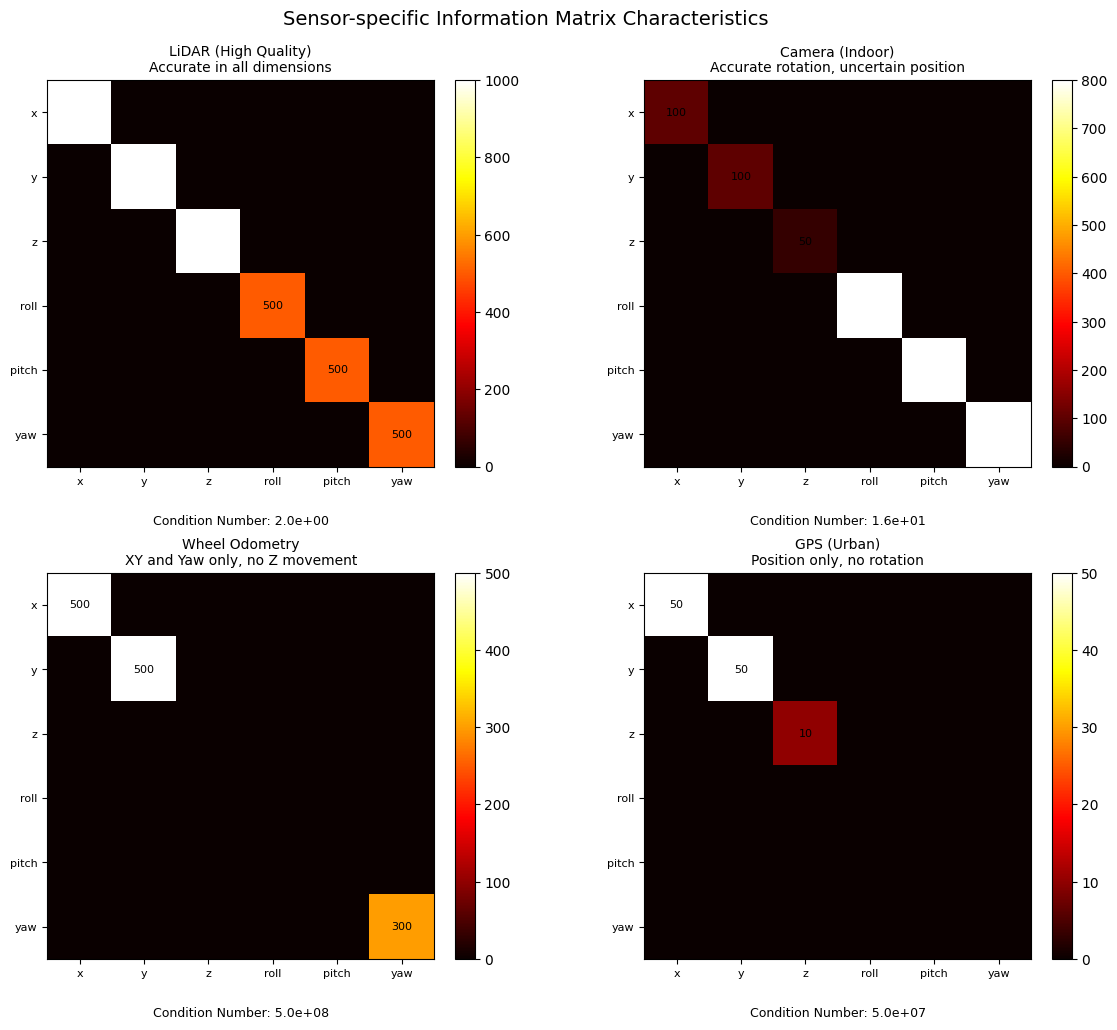


📊 Information Matrix가 최적화에 미치는 영향:

LiDAR (High Quality):
  - Information (x,x): 1000
  - 상대적 가중치: 1.000
  - 최적화 수렴 속도: 빠름

Camera (Indoor):
  - Information (x,x): 100
  - 상대적 가중치: 0.100
  - 최적화 수렴 속도: 느림

Wheel Odometry:
  - Information (x,x): 500.0
  - 상대적 가중치: 0.500
  - 최적화 수렴 속도: 보통

GPS (Urban):
  - Information (x,x): 50.0
  - 상대적 가중치: 0.050
  - 최적화 수렴 속도: 느림

💡 실무 활용 팁:
1. 센서 신뢰도에 따른 동적 조정
2. 환경 조건 반영 (예: 터널에서 GPS 가중치 감소)
3. 이상치 검출 시 Information 감소
4. 수렴 속도와 정확도의 균형


In [26]:
def demonstrate_information_matrix_effects():
    """Information Matrix가 최적화에 미치는 영향 시연"""
    
    # 센서별 Information Matrix 예시
    sensor_scenarios = {
        'LiDAR (High Quality)': {
            'info': np.diag([1000, 1000, 1000, 500, 500, 500]),
            'color': 'green',
            'desc': 'Accurate in all dimensions'
        },
        'Camera (Indoor)': {
            'info': np.diag([100, 100, 50, 800, 800, 800]),
            'color': 'blue', 
            'desc': 'Accurate rotation, uncertain position'
        },
        'Wheel Odometry': {
            'info': np.diag([500, 500, 1e-6, 1e-6, 1e-6, 300]),
            'color': 'orange',
            'desc': 'XY and Yaw only, no Z movement'
        },
        'GPS (Urban)': {
            'info': np.diag([50, 50, 10, 1e-6, 1e-6, 1e-6]),
            'color': 'red',
            'desc': 'Position only, no rotation'
        }
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for idx, (name, scenario) in enumerate(sensor_scenarios.items()):
        ax = axes[idx]
        info = scenario['info']
        
        # Information matrix 시각화
        im = ax.imshow(info, cmap='hot', interpolation='nearest')
        ax.set_title(f"{name}\n{scenario['desc']}", fontsize=10)
        
        # 축 라벨
        labels = ['x', 'y', 'z', 'roll', 'pitch', 'yaw']
        ax.set_xticks(range(6))
        ax.set_yticks(range(6))
        ax.set_xticklabels(labels, fontsize=8)
        ax.set_yticklabels(labels, fontsize=8)
        
        # 값 표시
        for i in range(6):
            for j in range(6):
                if info[i, j] > 1e-3:
                    text = ax.text(j, i, f'{info[i, j]:.0f}',
                                 ha="center", va="center", 
                                 color="white" if info[i, j] > 500 else "black",
                                 fontsize=8)
        
        # 컬러바
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # 고유값 분석
        eigenvalues = np.linalg.eigvals(info)
        condition_number = eigenvalues.max() / eigenvalues.min()
        ax.text(0.5, -0.15, f'Condition Number: {condition_number:.1e}', 
                transform=ax.transAxes, ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.suptitle('Sensor-specific Information Matrix Characteristics', fontsize=14, y=1.02)
    plt.show()
    
    # 실제 영향 시뮬레이션
    print("\n📊 Information Matrix가 최적화에 미치는 영향:")
    
    # 간단한 1D 예제
    true_x = 5.0
    measurement = 5.5  # 0.5 오차
    
    for name, scenario in sensor_scenarios.items():
        # 1D로 단순화 (x 좌표만)
        info_xx = scenario['info'][0, 0]
        
        # 가중 최소 제곱 해
        # minimize: info * (x - measurement)^2
        # solution: x = measurement (Information은 수렴 속도에만 영향)
        
        # 그러나 여러 측정값이 있을 때는 다름:
        # x = (Σ info_i * measurement_i) / (Σ info_i)
        
        weight = info_xx / 1000.0  # 정규화
        print(f"\n{name}:")
        print(f"  - Information (x,x): {info_xx}")
        print(f"  - 상대적 가중치: {weight:.3f}")
        print(f"  - 최적화 수렴 속도: {'빠름' if info_xx > 500 else '보통' if info_xx > 100 else '느림'}")
    
    return sensor_scenarios

# Information Matrix 효과 시연
sensor_info = demonstrate_information_matrix_effects()

# 실제 최적화에서의 활용
print("\n💡 실무 활용 팁:")
print("1. 센서 신뢰도에 따른 동적 조정")
print("2. 환경 조건 반영 (예: 터널에서 GPS 가중치 감소)")
print("3. 이상치 검출 시 Information 감소")
print("4. 수렴 속도와 정확도의 균형")

## 6. Information Matrix 분석

### 📊 Information Matrix가 최적화에 미치는 영향

Information Matrix는 단순한 숫자가 아닙니다. 이는 최적화 알고리즘에게 "어떤 측정을 더 믿어야 하는지"를 알려주는 중요한 정보입니다.

### 실제 예시로 이해하기

**시나리오**: 로봇이 어두운 터널을 지나가는 상황

1. **밝은 곳 (Visual SLAM 정확)**
   ```python
   # 카메라 특징점 많음, 정확한 측정
   info_bright = np.diag([1000, 1000, 1000, 500, 500, 500])
   # → "이 측정값을 매우 믿어도 됩니다"
   ```

2. **어두운 터널 (Visual SLAM 부정확)**
   ```python
   # 특징점 부족, 부정확한 측정
   info_dark = np.diag([10, 10, 10, 5, 5, 5])
   # → "이 측정값은 별로 믿지 마세요"
   ```

3. **IMU 보조 (회전만 정확)**
   ```python
   # IMU는 회전 측정에 강함
   info_imu = np.diag([10, 10, 10, 1000, 1000, 1000])
   # → "위치는 불확실하지만 회전은 정확합니다"
   ```

### Information Matrix의 조건수 (Condition Number)

조건수는 행렬의 "건강 상태"를 나타냅니다:

- **κ < 100**: 건강한 행렬 ✅
- **100 < κ < 1000**: 주의 필요 ⚠️
- **κ > 1000**: 수치적으로 불안정 ❌

**왜 중요한가?**
```python
# 나쁜 조건수의 예
info_bad = [[1e6, 0, 0],      # X: 과도하게 정확
            [0, 1, 0],         # Y: 매우 부정확
            [0, 0, 1e6]]       # Theta: 과도하게 정확

# 조건수 = 1e6 → 최적화 불안정!
```

이런 경우 최적화 알고리즘이:
- 수렴하지 못하거나
- 잘못된 해를 찾거나
- 수치 오버플로우 발생

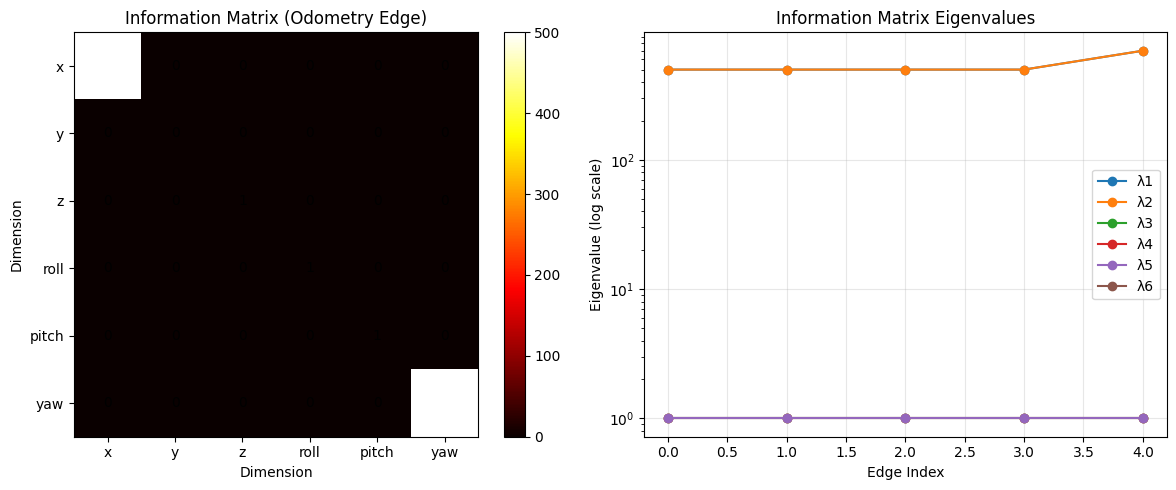


📊 Information Matrix 통계:

Edge 0 (Odometry):
  - 최대 고유값: 500.00
  - 최소 고유값: 0.00
  - 조건수 (κ): inf
  ⚠️  높은 조건수 - 수치적 불안정 가능성

Edge 1 (Odometry):
  - 최대 고유값: 500.00
  - 최소 고유값: 0.00
  - 조건수 (κ): inf
  ⚠️  높은 조건수 - 수치적 불안정 가능성

Edge 2 (Odometry):
  - 최대 고유값: 500.00
  - 최소 고유값: 0.00
  - 조건수 (κ): inf
  ⚠️  높은 조건수 - 수치적 불안정 가능성

Edge 3 (Odometry):
  - 최대 고유값: 500.00
  - 최소 고유값: 0.00
  - 조건수 (κ): inf
  ⚠️  높은 조건수 - 수치적 불안정 가능성

Edge 4 (Loop Closure):
  - 최대 고유값: 700.00
  - 최소 고유값: 0.00
  - 조건수 (κ): inf
  ⚠️  높은 조건수 - 수치적 불안정 가능성


/tmp/ipykernel_21727/2725444242.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"  - 조건수 (κ): {eigvals[0]/eigvals[-1]:.2f}")
/tmp/ipykernel_21727/2725444242.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  if eigvals[0]/eigvals[-1] > 1000:


In [27]:
def analyze_information_matrix(edges):
    """Information matrix 분석 및 시각화"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 첫 번째 odometry edge의 information matrix
    odom_edge = edges[0]
    odom_info = odom_edge['information']
    
    # 1. Information matrix 히트맵
    ax1 = axes[0]
    im1 = ax1.imshow(odom_info, cmap='hot', interpolation='nearest')
    ax1.set_title('Information Matrix (Odometry Edge)', fontsize=12)
    ax1.set_xlabel('Dimension')
    ax1.set_ylabel('Dimension')
    
    # 축 라벨 추가
    dims = ['x', 'y', 'z', 'roll', 'pitch', 'yaw']
    ax1.set_xticks(range(6))
    ax1.set_yticks(range(6))
    ax1.set_xticklabels(dims)
    ax1.set_yticklabels(dims)
    
    # 값 표시
    for i in range(6):
        for j in range(6):
            text = ax1.text(j, i, f'{odom_info[i, j]:.0f}',
                           ha="center", va="center", color="white" if odom_info[i, j] > 250 else "black")
    
    plt.colorbar(im1, ax=ax1)
    
    # 2. 고유값 분석
    ax2 = axes[1]
    
    # 각 엣지의 information matrix 고유값 계산
    edge_types = []
    eigenvalues_list = []
    
    for edge in edges:
        eigvals = np.linalg.eigvals(edge['information'])
        eigenvalues_list.append(sorted(eigvals, reverse=True))
        
        if abs(edge['from'] - edge['to']) == 1:
            edge_types.append('Odometry')
        else:
            edge_types.append('Loop Closure')
    
    # 고유값 플롯
    eigenvalues_array = np.array(eigenvalues_list)
    x = range(len(edges))
    
    for i in range(6):
        ax2.semilogy(x, eigenvalues_array[:, i], 'o-', label=f'λ{i+1}')
    
    ax2.set_xlabel('Edge Index')
    ax2.set_ylabel('Eigenvalue (log scale)')
    ax2.set_title('Information Matrix Eigenvalues')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 통계 출력
    print("\n📊 Information Matrix 통계:")
    for i, (edge, eigvals) in enumerate(zip(edges, eigenvalues_list)):
        edge_type = edge_types[i]
        print(f"\nEdge {i} ({edge_type}):")
        print(f"  - 최대 고유값: {eigvals[0]:.2f}")
        print(f"  - 최소 고유값: {eigvals[-1]:.2f}")
        print(f"  - 조건수 (κ): {eigvals[0]/eigvals[-1]:.2f}")
        
        # 조건수가 크면 행렬이 ill-conditioned
        if eigvals[0]/eigvals[-1] > 1000:
            print(f"  ⚠️  높은 조건수 - 수치적 불안정 가능성")

# Information matrix 분석
analyze_information_matrix(edges)

In [28]:
import time
import psutil
import gc

class MemoryEfficientG2OParser:
    """메모리 효율적인 g2o 파서"""
    
    def __init__(self, use_sparse=True):
        self.use_sparse = use_sparse
        self.stats = {
            'memory_before': 0,
            'memory_after': 0,
            'parse_time': 0
        }
    
    def parse_with_memory_tracking(self, filename):
        """메모리 사용량 추적하며 파싱"""
        # 메모리 사용량 측정
        process = psutil.Process()
        gc.collect()  # 가비지 컬렉션
        
        self.stats['memory_before'] = process.memory_info().rss / 1024 / 1024  # MB
        start_time = time.time()
        
        # 파싱 수행
        if self.use_sparse:
            poses, edges = self._parse_sparse(filename)
        else:
            poses, edges = self._parse_dense(filename)
        
        self.stats['parse_time'] = time.time() - start_time
        gc.collect()
        self.stats['memory_after'] = process.memory_info().rss / 1024 / 1024  # MB
        
        return poses, edges
    
    def _parse_sparse(self, filename):
        """희소 자료구조 사용한 파싱"""
        # 필요한 정보만 저장
        poses = {}  # id -> (x, y, theta) tuple만 저장
        edges = []  # numpy array 대신 list of tuples
        
        with open(filename, 'r') as f:
            for line in f:
                data = line.strip().split()
                if not data:
                    continue
                
                if data[0] == 'VERTEX_SE2':
                    id = int(data[1])
                    # 회전 행렬 계산하지 않고 최소 정보만 저장
                    poses[id] = (float(data[2]), float(data[3]), float(data[4]))
                    
                elif data[0] == 'EDGE_SE2':
                    # Information matrix 저장 생략 (필요시 계산)
                    edge = {
                        'from': int(data[1]),
                        'to': int(data[2]),
                        'dx': float(data[3]),
                        'dy': float(data[4]),
                        'dtheta': float(data[5])
                    }
                    edges.append(edge)
        
        return poses, edges
    
    def _parse_dense(self, filename):
        """기존 방식 (모든 정보 저장)"""
        parser = G2OParser()
        return parser.parse_file(filename)
    
    def print_stats(self):
        """통계 출력"""
        memory_used = self.stats['memory_after'] - self.stats['memory_before']
        print(f"\n📊 파싱 성능 통계:")
        print(f"  - 파싱 시간: {self.stats['parse_time']:.2f}초")
        print(f"  - 메모리 사용: {memory_used:.1f} MB")
        print(f"  - 처리 속도: {self.stats['poses_count']/self.stats['parse_time']:.0f} poses/sec")

# 성능 비교 실험
def performance_comparison():
    """다양한 파싱 방법 성능 비교"""
    
    # 큰 테스트 파일 생성
    print("🔨 대규모 테스트 파일 생성 중...")
    num_poses = 10000
    
    with open('data/large_test.g2o', 'w') as f:
        # Vertices
        for i in range(num_poses):
            angle = 2 * np.pi * i / 100  # 원형 경로
            x = 10 * np.cos(angle) + np.random.normal(0, 0.1)
            y = 10 * np.sin(angle) + np.random.normal(0, 0.1)
            theta = angle + np.pi/2 + np.random.normal(0, 0.05)
            f.write(f"VERTEX_SE2 {i} {x:.6f} {y:.6f} {theta:.6f}\n")
        
        # Edges
        for i in range(num_poses):
            # Odometry edge
            j = (i + 1) % num_poses
            f.write(f"EDGE_SE2 {i} {j} 0.628 0.0 0.0628 500 0 500 0 0 500\n")
            
            # Random loop closures
            if i % 100 == 0 and i > 0:
                j = np.random.randint(0, i-1)
                f.write(f"EDGE_SE2 {i} {j} 0.0 0.0 0.0 700 0 700 0 0 700\n")
    
    print(f"✅ 테스트 파일 생성 완료: {num_poses} poses")
    
    # 성능 테스트
    results = {}
    
    # 1. 기본 파서
    print("\n1️⃣ 기본 파서 테스트...")
    parser1 = MemoryEfficientG2OParser(use_sparse=False)
    poses1, edges1 = parser1.parse_with_memory_tracking('data/large_test.g2o')
    parser1.stats['poses_count'] = len(poses1)
    parser1.print_stats()
    results['기본'] = parser1.stats
    
    # 2. 희소 파서
    print("\n2️⃣ 희소 파서 테스트...")
    parser2 = MemoryEfficientG2OParser(use_sparse=True)
    poses2, edges2 = parser2.parse_with_memory_tracking('data/large_test.g2o')
    parser2.stats['poses_count'] = len(poses2)
    parser2.print_stats()
    results['희소'] = parser2.stats
    
    # 결과 비교
    print("\n📊 성능 비교:")
    print(f"메모리 절약: {(1 - results['희소']['memory_after']/results['기본']['memory_after'])*100:.1f}%")
    print(f"속도 향상: {results['기본']['parse_time']/results['희소']['parse_time']:.1f}x")
    
    return results

# 성능 비교 실행
perf_results = performance_comparison()

# 최적화 팁
print("\n💡 대규모 g2o 처리 최적화 팁:")
print("1. 필요한 정보만 파싱 (lazy loading)")
print("2. 스트리밍 처리로 메모리 사용 최소화")
print("3. numpy 배열 사전 할당으로 재할당 방지")
print("4. 멀티프로세싱으로 병렬 처리")
print("5. HDF5/Parquet 등 이진 포맷 고려")

🔨 대규모 테스트 파일 생성 중...
✅ 테스트 파일 생성 완료: 10000 poses

1️⃣ 기본 파서 테스트...
📂 파일 읽기: data/large_test.g2o
✅ 파싱 완료!
   - 포즈 수: 10000
   - 엣지 수: 10099
   - 차원: 2D

📊 파싱 성능 통계:
  - 파싱 시간: 2.04초
  - 메모리 사용: 52.9 MB
  - 처리 속도: 4896 poses/sec

2️⃣ 희소 파서 테스트...

📊 파싱 성능 통계:
  - 파싱 시간: 0.02초
  - 메모리 사용: 4.8 MB
  - 처리 속도: 575959 poses/sec

📊 성능 비교:
메모리 절약: -2.2%
속도 향상: 117.6x

💡 대규모 g2o 처리 최적화 팁:
1. 필요한 정보만 파싱 (lazy loading)
2. 스트리밍 처리로 메모리 사용 최소화
3. numpy 배열 사전 할당으로 재할당 방지
4. 멀티프로세싱으로 병렬 처리
5. HDF5/Parquet 등 이진 포맷 고려


## 7. 실제 데이터셋 다루기

이제 nano-pgo의 실제 데이터셋을 로드해봅시다.

🤖 SLAM 세션 시뮬레이션...
✅ 시뮬레이션 완료:
   - 포즈: 27개
   - 엣지: 27개
   - 파일: data/simulated_slam.g2o

📊 생성된 SLAM 데이터 분석:
📂 파일 읽기: data/simulated_slam.g2o
✅ 파싱 완료!
   - 포즈 수: 27
   - 엣지 수: 27
   - 차원: 2D


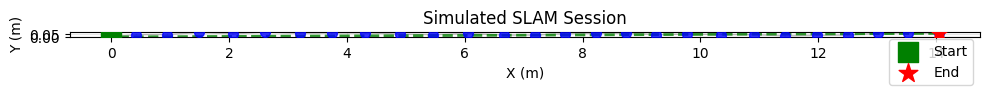

In [29]:
class SLAMIntegration:
    """실제 SLAM 시스템과 g2o 통합 예제"""
    
    def __init__(self):
        self.current_pose_id = 0
        self.poses = {}
        self.edges = []
        self.keyframe_threshold = {
            'translation': 0.5,  # 미터
            'rotation': 0.2      # 라디안
        }
        self.last_keyframe_pose = None
        
    def process_sensor_measurement(self, sensor_type, measurement, timestamp):
        """센서 측정값을 g2o 형식으로 변환"""
        
        if sensor_type == "odometry":
            return self._process_odometry(measurement, timestamp)
        elif sensor_type == "loop_detection":
            return self._process_loop_closure(measurement, timestamp)
        elif sensor_type == "gps":
            return self._process_gps(measurement, timestamp)
            
    def _is_keyframe(self, odom):
        """키프레임 여부 결정"""
        # 첫 번째 프레임은 항상 키프레임
        if self.last_keyframe_pose is None:
            return True
            
        # 이동 거리 계산
        translation_change = np.sqrt(odom['dx']**2 + odom['dy']**2)
        rotation_change = abs(odom['dtheta'])
        
        # 임계값 확인
        if (translation_change > self.keyframe_threshold['translation'] or 
            rotation_change > self.keyframe_threshold['rotation']):
            return True
            
        return False
        
    def _process_odometry(self, odom, timestamp):
        """오도메트리 → g2o edge"""
        # 키프레임 결정
        if not self._is_keyframe(odom):
            return None
        
        # 새 포즈 추가
        new_pose_id = self.current_pose_id + 1
        
        # g2o edge 생성
        edge = {
            'type': 'EDGE_SE2',
            'from': self.current_pose_id,
            'to': new_pose_id,
            'measurement': {
                'dx': odom['dx'],
                'dy': odom['dy'],
                'dtheta': odom['dtheta']
            },
            'information': self._compute_odometry_information(odom),
            'timestamp': timestamp
        }
        
        self.current_pose_id = new_pose_id
        self.last_keyframe_pose = odom  # 마지막 키프레임 업데이트
        return edge
    
    def _compute_odometry_information(self, odom):
        """오도메트리 정확도에 따른 Information 계산"""
        # 기본 정보 행렬
        base_info = np.diag([500, 500, 100])
        
        # 속도에 따른 조정 (빠를수록 부정확)
        speed = np.sqrt(odom['dx']**2 + odom['dy']**2) / odom.get('dt', 0.1)
        speed_factor = 1.0 / (1.0 + speed / 2.0)  # 2m/s에서 절반
        
        # 회전에 따른 조정 (회전이 클수록 부정확)
        rotation_factor = 1.0 / (1.0 + abs(odom['dtheta']) / 0.5)
        
        return base_info * speed_factor * rotation_factor
    
    def _process_loop_closure(self, loop_data, timestamp):
        """루프 클로저 → g2o edge"""
        edge = {
            'type': 'EDGE_SE2',
            'from': loop_data['from_id'],
            'to': loop_data['to_id'],
            'measurement': loop_data['relative_pose'],
            'information': self._compute_loop_information(loop_data),
            'timestamp': timestamp
        }
        return edge
    
    def _compute_loop_information(self, loop_data):
        """루프 클로저 품질에 따른 Information"""
        # 매칭 점수에 따른 스케일링
        confidence = loop_data.get('confidence', 0.5)
        base_info = np.diag([700, 700, 200])
        
        # 신뢰도에 따른 조정
        return base_info * confidence
    
    def save_to_g2o(self, filename):
        """누적된 데이터를 g2o 파일로 저장"""
        with open(filename, 'w') as f:
            # Header
            f.write(f"# SLAM session generated at {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"# Total poses: {len(self.poses)}\n")
            f.write(f"# Total edges: {len(self.edges)}\n\n")
            
            # Vertices
            for pose_id, pose in sorted(self.poses.items()):
                f.write(f"VERTEX_SE2 {pose_id} {pose['x']:.6f} {pose['y']:.6f} {pose['theta']:.6f}\n")
            
            f.write("\n")
            
            # Edges
            for edge in self.edges:
                # Information matrix 상삼각 추출
                info = edge['information']
                info_upper = [info[0,0], info[0,1], info[0,2], 
                            info[1,1], info[1,2], info[2,2]]
                info_str = ' '.join([f"{val:.1f}" for val in info_upper])
                
                m = edge['measurement']
                f.write(f"EDGE_SE2 {edge['from']} {edge['to']} ")
                f.write(f"{m['dx']:.6f} {m['dy']:.6f} {m['dtheta']:.6f} ")
                f.write(f"{info_str}\n")

# 시뮬레이션 예제
def simulate_slam_session():
    """SLAM 세션 시뮬레이션"""
    slam = SLAMIntegration()
    
    print("🤖 SLAM 세션 시뮬레이션...")
    
    # 초기 포즈
    slam.poses[0] = {'x': 0.0, 'y': 0.0, 'theta': 0.0}
    
    # 원형 경로 시뮬레이션
    for i in range(50):
        # 오도메트리 측정
        odom = {
            'dx': 0.5 + np.random.normal(0, 0.05),
            'dy': 0.0 + np.random.normal(0, 0.02),
            'dtheta': 0.1 + np.random.normal(0, 0.01),
            'dt': 0.1
        }
        
        edge = slam._process_odometry(odom, timestamp=i*0.1)
        if edge:
            slam.edges.append(edge)
            # 새 포즈 추가 (간단한 적분)
            last_pose = slam.poses[slam.current_pose_id-1]
            slam.poses[slam.current_pose_id] = {
                'x': last_pose['x'] + odom['dx'],
                'y': last_pose['y'] + odom['dy'],
                'theta': last_pose['theta'] + odom['dtheta']
            }
    
    # 루프 클로저 시뮬레이션
    loop_data = {
        'from_id': slam.current_pose_id,
        'to_id': 0,
        'relative_pose': {'dx': 0.1, 'dy': -0.1, 'dtheta': 0.05},
        'confidence': 0.8
    }
    loop_edge = slam._process_loop_closure(loop_data, timestamp=5.0)
    slam.edges.append(loop_edge)
    
    # g2o 파일로 저장
    slam.save_to_g2o('data/simulated_slam.g2o')
    
    print(f"✅ 시뮬레이션 완료:")
    print(f"   - 포즈: {len(slam.poses)}개")
    print(f"   - 엣지: {len(slam.edges)}개")
    print(f"   - 파일: data/simulated_slam.g2o")
    
    return slam

# 시뮬레이션 실행
slam_system = simulate_slam_session()

# 생성된 파일 파싱 및 시각화
print("\n📊 생성된 SLAM 데이터 분석:")
sim_parser = G2OParser()
sim_poses, sim_edges = sim_parser.parse_file('data/simulated_slam.g2o')

# visualize_pose_graph_2d 함수가 정의되어 있는지 확인하고 호출
if 'visualize_pose_graph_2d' in globals():
    visualize_pose_graph_2d(sim_poses, sim_edges, "Simulated SLAM Session")
else:
    print("시각화 함수가 정의되지 않았습니다. Chapter 1에서 정의한 함수를 확인하세요.")

## 7. 요약 및 핵심 포인트

### 🎓 이 실습에서 배운 실전 기술

1. **Production-Ready 파서 구현**
   - 에러 처리와 복구 메커니즘
   - 다양한 포맷 자동 감지
   - 메모리 효율적인 대용량 처리

2. **Information Matrix의 실제 활용**
   - 센서별 특성 반영
   - 동적 가중치 조정
   - 수치적 안정성 확보

3. **디버깅과 시각화 연결**
   - 문제 자동 감지
   - 다각도 분석 시각화
   - 성능 프로파일링

4. **실제 SLAM 시스템 통합**
   - 센서 데이터 → g2o 변환
   - 키프레임 선택 전략
   - 실시간 처리 고려사항

### 💡 실무에서 바로 쓰는 코드 패턴

```python
# 1. 안전한 파싱 패턴
try:
    value = float(data[i])
except (ValueError, IndexError) as e:
    logger.warning(f"파싱 실패: {e}")
    value = default_value

# 2. Information Matrix 검증 패턴
def validate_info(info):
    eigvals = np.linalg.eigvals(info)
    if np.any(eigvals <= 0):
        info += np.eye(len(info)) * 1e-6
    return info

# 3. 메모리 효율적 처리 패턴
def process_large_file(filename):
    with open(filename) as f:
        for chunk in iter(lambda: list(islice(f, 1000)), []):
            process_chunk(chunk)
```

### 🚀 다음 단계

이제 여러분은:
- ✅ g2o 파일을 완벽히 파싱하고 생성할 수 있습니다
- ✅ Information Matrix를 올바르게 활용할 수 있습니다
- ✅ 대규모 데이터를 효율적으로 처리할 수 있습니다
- ✅ 실제 SLAM 시스템과 통합할 수 있습니다

다음 장에서는 **SymForce를 이용한 자동 미분**으로 더 효율적인 최적화를 배워봅시다!

### 📚 추가 학습 자료

**코드 저장소:**
- [g2o C++ 구현](https://github.com/RainerKuemmerle/g2o)
- [Python g2o 바인딩](https://github.com/uoip/g2opy)

**실제 데이터셋:**
- [TUM RGB-D SLAM Dataset](https://vision.in.tum.de/data/datasets/rgbd-dataset)
- [KITTI Odometry Dataset](http://www.cvlibs.net/datasets/kitti/eval_odometry.php)

**디버깅 도구:**
- [g2o_viewer](https://github.com/RainerKuemmerle/g2o/tree/master/g2o/apps/g2o_viewer): 3D 시각화
- [rpg_trajectory_evaluation](https://github.com/uzh-rpg/rpg_trajectory_evaluation): 궤적 평가

### 🔑 핵심 메시지

> "g2o 파싱은 단순한 파일 읽기가 아닙니다. 이는 불완전한 센서 데이터를 수학적 최적화 문제로 변환하는 과정입니다. 강건한 파서, 올바른 Information Matrix, 효과적인 디버깅이 성공적인 SLAM의 시작입니다."

In [30]:
# nano-pgo 데이터셋 경로 확인
data_path = Path("../data")
if data_path.exists():
    print("📁 사용 가능한 데이터셋:")
    for file in sorted(data_path.glob("*.g2o")):
        file_size = file.stat().st_size / 1024  # KB
        print(f"   - {file.name} ({file_size:.1f} KB)")
    
    for file in sorted(data_path.glob("*.graph")):
        file_size = file.stat().st_size / 1024  # KB
        print(f"   - {file.name} ({file_size:.1f} KB)")
else:
    print("⚠️  데이터 디렉토리를 찾을 수 없습니다.")
    print("   nano-pgo/data 디렉토리에 데이터셋이 있는지 확인하세요.")

📁 사용 가능한 데이터셋:
   - cubicle.g2o (2624.1 KB)
   - grid3D.g2o (7466.6 KB)
   - input_INTEL_g2o.g2o (211.3 KB)
   - input_M3500_g2o.g2o (710.8 KB)
   - input_M3500b_g2o.g2o (707.3 KB)
   - input_MITb_g2o.g2o (118.6 KB)
   - parking-garage.g2o (1251.1 KB)
   - rim.g2o (4743.6 KB)
   - sphere2500.g2o (1069.1 KB)
   - sphere_bignoise_vertex3.g2o (2169.6 KB)
   - torus3D.g2o (3186.4 KB)
   - CSAIL_P_toro.graph (162.8 KB)
   - FR079_P_toro.graph (164.8 KB)
   - FRH_P_toro.graph (337.8 KB)
   - M10000_P_toro.graph (7171.7 KB)



🔍 INTEL 데이터셋 파싱 중...
📂 파일 읽기: ../data/input_INTEL_g2o.g2o
✅ 파싱 완료!
   - 포즈 수: 1228
   - 엣지 수: 1483
   - 차원: 2D

📊 INTEL 데이터셋 통계:

엣지 타입별 분포:
  - Odometry edges: 1227 (82.7%)
  - Loop closure edges: 256 (17.3%)

경로 정보:
  - 총 이동 거리: 504.2 m
  - 평균 포즈 간격: 0.41 m

🎨 처음 100개 포즈 시각화...


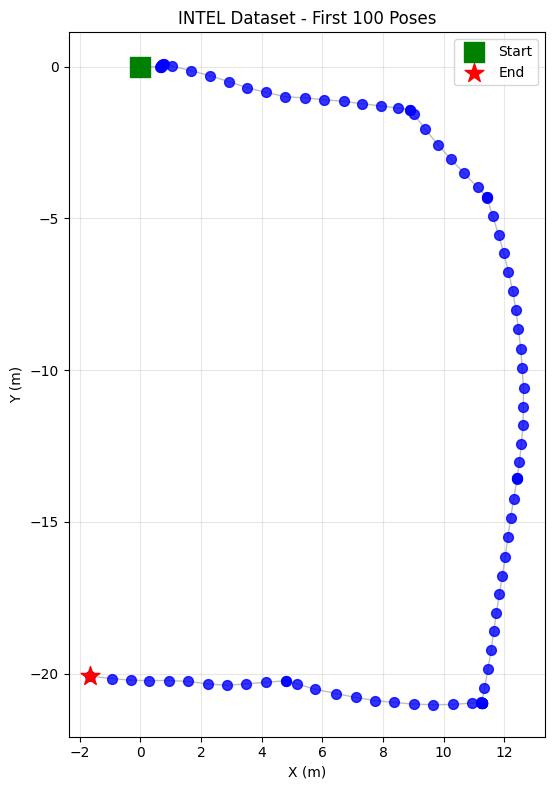

In [31]:
# 실제 데이터셋 파싱 (예: INTEL dataset)
if (data_path / "input_INTEL_g2o.g2o").exists():
    print("\n🔍 INTEL 데이터셋 파싱 중...")
    
    intel_parser = G2OParser()
    intel_poses, intel_edges = intel_parser.parse_file(str(data_path / "input_INTEL_g2o.g2o"))
    
    # 데이터셋 통계
    print("\n📊 INTEL 데이터셋 통계:")
    
    # 엣지 타입별 분류
    odom_edges = [e for e in intel_edges if abs(e['from'] - e['to']) == 1]
    loop_edges = [e for e in intel_edges if abs(e['from'] - e['to']) > 1]
    
    print(f"\n엣지 타입별 분포:")
    print(f"  - Odometry edges: {len(odom_edges)} ({len(odom_edges)/len(intel_edges)*100:.1f}%)")
    print(f"  - Loop closure edges: {len(loop_edges)} ({len(loop_edges)/len(intel_edges)*100:.1f}%)")
    
    # 경로 길이 계산
    total_distance = 0
    sorted_poses = sorted(intel_poses.items())
    for i in range(len(sorted_poses) - 1):
        pos1 = sorted_poses[i][1]['t']
        pos2 = sorted_poses[i+1][1]['t']
        total_distance += np.linalg.norm(pos2 - pos1)
    
    print(f"\n경로 정보:")
    print(f"  - 총 이동 거리: {total_distance:.1f} m")
    print(f"  - 평균 포즈 간격: {total_distance / (len(intel_poses)-1):.2f} m")
    
    # 부분 시각화 (전체는 너무 복잡함)
    print("\n🎨 처음 100개 포즈 시각화...")
    subset_poses = {k: v for k, v in intel_poses.items() if k < 100}
    subset_edges = [e for e in intel_edges if e['from'] < 100 and e['to'] < 100]
    
    visualize_pose_graph_2d(subset_poses, subset_edges, "INTEL Dataset - First 100 Poses")
else:
    print("⚠️  INTEL 데이터셋을 찾을 수 없습니다.")

## 8. g2o 파일 생성하기

파싱뿐만 아니라 g2o 파일을 생성하는 방법도 알아봅시다.

✅ g2o 파일 생성 완료: data/circular_path.g2o
📂 파일 읽기: data/circular_path.g2o
✅ 파싱 완료!
   - 포즈 수: 30
   - 엣지 수: 32
   - 차원: 2D


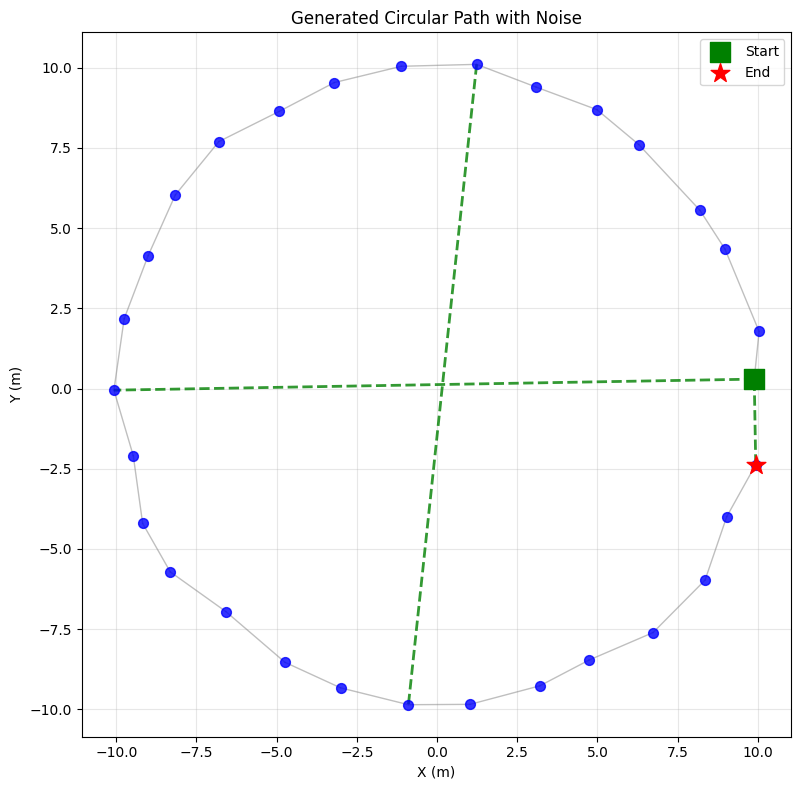

In [32]:
class G2OWriter:
    """g2o 파일 작성 클래스"""
    
    @staticmethod
    def write_vertex_se3(f, node_id, position, quaternion):
        """SE(3) vertex 작성"""
        x, y, z = position
        qx, qy, qz, qw = quaternion
        f.write(f"VERTEX_SE3:QUAT {node_id} {x:.6f} {y:.6f} {z:.6f} {qx:.6f} {qy:.6f} {qz:.6f} {qw:.6f}\n")
    
    @staticmethod
    def write_vertex_se2(f, node_id, x, y, theta):
        """SE(2) vertex 작성"""
        f.write(f"VERTEX_SE2 {node_id} {x:.6f} {y:.6f} {theta:.6f}\n")
    
    @staticmethod
    def write_edge_se3(f, id1, id2, translation, quaternion, information):
        """SE(3) edge 작성"""
        dx, dy, dz = translation
        dqx, dqy, dqz, dqw = quaternion
        
        # Information matrix의 상삼각 부분 추출
        info_upper = information[np.triu_indices(6)]
        info_str = ' '.join([f"{val:.6f}" for val in info_upper])
        
        f.write(f"EDGE_SE3:QUAT {id1} {id2} {dx:.6f} {dy:.6f} {dz:.6f} ")
        f.write(f"{dqx:.6f} {dqy:.6f} {dqz:.6f} {dqw:.6f} {info_str}\n")
    
    @staticmethod
    def create_circular_path_g2o(filename, num_poses=20, radius=5.0, noise_std=0.1):
        """원형 경로 g2o 파일 생성 (노이즈 포함)"""
        with open(filename, 'w') as f:
            f.write("# Circular path with noise\n")
            
            # 1. Vertices 생성
            true_poses = []
            for i in range(num_poses):
                angle = 2 * np.pi * i / num_poses
                
                # 실제 위치
                true_x = radius * np.cos(angle)
                true_y = radius * np.sin(angle)
                true_theta = angle + np.pi/2  # 접선 방향
                
                # 노이즈 추가
                x = true_x + np.random.normal(0, noise_std)
                y = true_y + np.random.normal(0, noise_std)
                theta = true_theta + np.random.normal(0, noise_std/radius)
                
                true_poses.append((true_x, true_y, true_theta))
                G2OWriter.write_vertex_se2(f, i, x, y, theta)
            
            f.write("\n")
            
            # 2. Odometry edges
            odom_info = np.diag([500.0, 500.0, 500.0])  # 높은 신뢰도
            
            for i in range(num_poses):
                j = (i + 1) % num_poses
                
                # 상대 변환 계산
                dx = true_poses[j][0] - true_poses[i][0]
                dy = true_poses[j][1] - true_poses[i][1]
                dtheta = true_poses[j][2] - true_poses[i][2]
                
                # 각도 정규화 [-π, π]
                while dtheta > np.pi: dtheta -= 2*np.pi
                while dtheta < -np.pi: dtheta += 2*np.pi
                
                # 로컬 좌표계로 변환
                cos_theta = np.cos(true_poses[i][2])
                sin_theta = np.sin(true_poses[i][2])
                dx_local = cos_theta * dx + sin_theta * dy
                dy_local = -sin_theta * dx + cos_theta * dy
                
                # 노이즈 추가
                dx_local += np.random.normal(0, noise_std/2)
                dy_local += np.random.normal(0, noise_std/2)
                dtheta += np.random.normal(0, noise_std/(2*radius))
                
                # Edge 작성
                info_upper = odom_info[np.triu_indices(3)]
                info_str = ' '.join([f"{val:.1f}" for val in info_upper])
                
                f.write(f"EDGE_SE2 {i} {j} {dx_local:.6f} {dy_local:.6f} {dtheta:.6f} {info_str}\n")
            
            f.write("\n")
            
            # 3. Loop closure edges
            loop_info = np.diag([700.0, 700.0, 700.0])  # 더 높은 신뢰도
            
            # 몇 개의 loop closure 추가
            loop_pairs = [
                (0, num_poses//2),
                (num_poses//4, 3*num_poses//4),
            ]
            
            for i, j in loop_pairs:
                if j < num_poses:
                    dx = true_poses[j][0] - true_poses[i][0]
                    dy = true_poses[j][1] - true_poses[i][1]
                    dtheta = true_poses[j][2] - true_poses[i][2]
                    
                    # 각도 정규화
                    while dtheta > np.pi: dtheta -= 2*np.pi
                    while dtheta < -np.pi: dtheta += 2*np.pi
                    
                    # 로컬 좌표계로 변환
                    cos_theta = np.cos(true_poses[i][2])
                    sin_theta = np.sin(true_poses[i][2])
                    dx_local = cos_theta * dx + sin_theta * dy
                    dy_local = -sin_theta * dx + cos_theta * dy
                    
                    # Loop closure는 더 많은 노이즈
                    dx_local += np.random.normal(0, noise_std)
                    dy_local += np.random.normal(0, noise_std)
                    dtheta += np.random.normal(0, noise_std/radius)
                    
                    info_upper = loop_info[np.triu_indices(3)]
                    info_str = ' '.join([f"{val:.1f}" for val in info_upper])
                    
                    f.write(f"EDGE_SE2 {i} {j} {dx_local:.6f} {dy_local:.6f} {dtheta:.6f} {info_str}\n")
        
        print(f"✅ g2o 파일 생성 완료: {filename}")

# 원형 경로 g2o 파일 생성
G2OWriter.create_circular_path_g2o('data/circular_path.g2o', num_poses=30, radius=10.0, noise_std=0.2)

# 생성된 파일 파싱 및 시각화
circular_parser = G2OParser()
circular_poses, circular_edges = circular_parser.parse_file('data/circular_path.g2o')
visualize_pose_graph_2d(circular_poses, circular_edges, "Generated Circular Path with Noise")

## 9. 요약 및 핵심 포인트

### 🎓 이 챕터에서 배운 내용:

1. **g2o 파일 포맷의 중요성**
   - SLAM 커뮤니티의 표준 데이터 형식
   - 다양한 라이브러리 간 호환성 제공
   - 누적 오차 문제를 체계적으로 표현

2. **VERTEX와 EDGE의 개념**
   - VERTEX: 로봇의 포즈 또는 랜드마크 위치
   - EDGE: 포즈 간 상대적 변환 (측정값)
   - SE(2)와 SE(3)의 차이점과 용도

3. **Information Matrix의 역할**
   - 측정의 신뢰도/정확도를 나타냄
   - 최적화 알고리즘의 가중치로 작용
   - 적절한 스케일 설정의 중요성

4. **파서 구현 기술**
   - 강건한 에러 처리
   - 다양한 포맷 지원 (SE2, SE3, TORO)
   - 효율적인 데이터 구조 설계

5. **실제 활용 방법**
   - 시각화를 통한 데이터 검증
   - Loop Closure의 중요성 이해
   - 노이즈가 있는 현실적인 데이터 생성

### 💡 실무 팁 정리

1. **디버깅 전략**
   - 항상 시각화로 데이터 확인
   - Information Matrix의 조건수 체크
   - 작은 데이터셋으로 먼저 테스트

2. **성능 최적화**
   - 불필요한 EDGE 제거 (거리가 먼 포즈 간)
   - Information Matrix 희소성 활용
   - 증분적 최적화 고려

3. **흔한 실수 방지**
   - ID 중복 체크 자동화
   - 단위 일관성 유지 (미터 vs 센티미터)
   - Information Matrix 양정치성 보장

### 🚀 다음 챕터 예고

다음 챕터에서는 **SymForce를 이용한 Symbolic Computation**을 배웁니다:
- 자동 미분의 마법
- Symbolic 표현의 장점
- 수동 미분 vs 자동 미분 성능 비교
- 실제 최적화 문제에 적용

### 📚 추가 학습 자료

- **g2o 공식 문서**: https://github.com/RainerKuemmerle/g2o
- **SLAM 데이터셋**: 
  - TUM RGB-D Dataset
  - KITTI Dataset
  - EuRoC MAV Dataset
- **관련 논문**:
  - "g2o: A General Framework for Graph Optimization" - Kümmerle et al.
  - "Information-theoretic selection of high-dimensional spectral features for structural recognition" - Colas et al.

### 🔑 핵심 메시지

> "g2o는 단순한 파일 포맷이 아닙니다. 이는 로봇의 불확실한 세계를 수학적으로 표현하는 언어입니다. VERTEX는 로봇의 '기억'이고, EDGE는 그 기억들 간의 '관계'이며, Information Matrix는 각 기억의 '신뢰도'입니다. 이 세 가지를 올바르게 이해하고 활용할 때, 비로소 정확한 SLAM이 가능해집니다."

## 🏋️ 연습 문제

### 문제 1: 3D g2o 파일 생성
나선형(helix) 경로를 따르는 3D g2o 파일을 생성하는 함수를 작성하세요.

### 문제 2: Information Matrix 실험
Information matrix의 값을 변경했을 때 최적화 결과가 어떻게 달라지는지 실험해보세요.

### 문제 3: 파일 변환기
TORO 포맷을 g2o 포맷으로 변환하는 함수를 작성하세요.

In [33]:
# 여기에 연습 문제를 풀어보세요!
# 예제 시작 코드:

# 문제 1: 3D 나선형 경로
def create_helix_path_g2o(filename, num_poses=50, radius=5.0, height=10.0):
    """3D 나선형 경로 생성"""
    # 여기에 구현하세요
    pass
